In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun 21 17:32:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install keras_hist_graph

In [3]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten, Input, ZeroPadding2D,InputLayer
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, SGD
from keras.callbacks import History, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.constraints import unit_norm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras_hist_graph import plot_history
%matplotlib inline

In [4]:
pip install livelossplot

In [9]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions, preprocess_input, VGG16
from livelossplot.inputs.keras import PlotLossesCallback

In [6]:
#set the training path
training_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/training_data'
#set the validation path
validation_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/validation_data'
#set the test path
test_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data'

In [ ]:
breeds=['chow','collie','cairn','dhole','dingo']

In [ ]:
def create_dataset(folder_path,breed_classes):
  
  image_arrays=[]
  image_classes=[]

  for breed in os.listdir(folder_path):
    if breed in breed_classes:
      breed_path=os.path.join(folder_path,breed)
      for img in os.listdir(breed_path):
        
        image=cv2.imread(os.path.join(breed_path,img),cv2.IMREAD_UNCHANGED)
        image = image.astype('float64')
        image /= 255

        image_arrays.append(image)
        image_classes.append(breed)


  return image_arrays , image_classes



In [ ]:
img_data, class_names=create_dataset(training_path, breeds)

In [ ]:
img_data_val, class_names_val=create_dataset(validation_path, breeds)

In [ ]:
img_data_test, class_names_test=create_dataset(test_path, breeds)

Next, we prepare the labels as a list of label encoded inputs from a **breed list** that we chose 

In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(class_names))}
target_val=  [target_dict[class_names[i]] for i in range(len(class_names))]

In [ ]:
target_dict_val={k: v for v, k in enumerate(np.unique(class_names_val))}
target_val_val=  [target_dict_val[class_names_val[i]] for i in range(len(class_names_val))]

In [ ]:
target_dict_test={k: v for v, k in enumerate(np.unique(class_names_test))}
target_val_test=  [target_dict_test[class_names_test[i]] for i in range(len(class_names_test))]

In [ ]:
conv=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
conv.trainable=False

In [ ]:
conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def set_data(x,y):
  
  feature=np.array(x, np.float64)
  
  label=tf.keras.utils.to_categorical(np.array(y, dtype=np.float64))

  return feature, label

In [ ]:
train_features, train_labels=set_data(img_data,target_val)

In [ ]:
val_features,val_labels=set_data(img_data_val,target_val_val)

In [ ]:
train_features.shape

(553, 224, 224, 3)

In [ ]:
features=conv.predict(train_features)

In [ ]:
val_features=conv.predict(val_features)

In [ ]:
val_features.shape

(172, 7, 7, 512)

In [ ]:
features.shape

(553, 7, 7, 512)

In [ ]:
model_base=Sequential()
model_base.add(InputLayer((7,7,512)))
model_base.add(Flatten())
model_base.add(Dense(512, activation='relu',input_shape=(None,25088)))
model_base.add(Dropout(0.3))
model_base.add(Dense(5,activation='softmax'))

In [ ]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 12,848,133
Trainable params: 12,848,133
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history_base=model_base.fit(x=features,y=train_labels,batch_size=20, epochs=1000, verbose=2,validation_data=(val_features,val_labels), callbacks=[History(),
                                                          ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/base_line', monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1)
              ]
    )

Epoch 1/1000
28/28 - 1s - loss: 3.7059 - acc: 0.4195 - val_loss: 1.6065 - val_acc: 0.4884

Epoch 00001: val_acc improved from -inf to 0.48837, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/base_line
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/base_line/assets
Epoch 2/1000
28/28 - 0s - loss: 0.6562 - acc: 0.7830 - val_loss: 0.7367 - val_acc: 0.7500

Epoch 00002: val_acc improved from 0.48837 to 0.75000, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/base_line
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/base_line/assets
Epoch 3/1000
28/28 - 0s - loss: 0.2400 - acc: 0.9259 - val_loss: 0.7113 - val_acc: 0.7209

Epoch 00003: val_acc did not improve from 0.75000
Epoch 4/1000
28/28 - 0s - loss: 0.1332 - acc: 0.9602 - val_loss: 0.7413 - val_acc: 0.7849

Epoch 00004: va

In [ ]:
test_features,test_labels=set_data(img_data_test,target_val_test)

In [ ]:
val_features.shape

(172, 7, 7, 512)

In [ ]:
test_features=conv.predict(test_features)

In [ ]:
model_base.evaluate(test_features,test_labels)

4/4 [==============================] - 0s 3ms/step - loss: 0.9160 - acc: 0.6693


[0.9160397052764893, 0.6692913174629211]

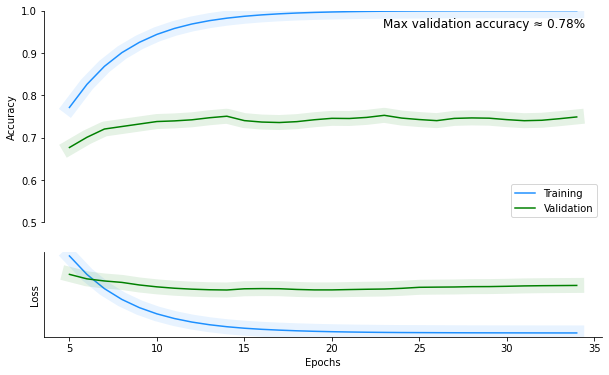

In [ ]:
plot_history(history_base,xkcd=False)

## Working with data augmentation 

In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 172 images belonging to 5 classes.


In [ ]:
model_aug=Sequential()
model_aug.add(conv)
#model_aug.add(InputLayer((7,7,512)))
model_aug.add(Flatten())
model_aug.add(Dense(512, activation='relu',input_shape=(None,25088)))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(5,activation='softmax'))

model_aug.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

history_aug=model_aug.fit(train_features,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/Aug_data',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1)
              ]
    )

Epoch 1/1000
28/28 - 12s - loss: 4.3919 - acc: 0.3906 - val_loss: 0.9537 - val_acc: 0.6744

Epoch 00001: val_acc improved from -inf to 0.67442, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/Aug_data
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/Aug_data/assets
Epoch 2/1000
28/28 - 2s - loss: 0.6886 - acc: 0.7703 - val_loss: 0.7595 - val_acc: 0.6977

Epoch 00002: val_acc improved from 0.67442 to 0.69767, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/Aug_data
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/Aug_data/assets
Epoch 3/1000
28/28 - 2s - loss: 0.2273 - acc: 0.9259 - val_loss: 0.8273 - val_acc: 0.6977

Epoch 00003: val_acc did not improve from 0.69767
Epoch 4/1000
28/28 - 2s - loss: 0.1348 - acc: 0.9620 - val_loss: 0.8484 - val_acc: 0.6802

Epoch 00004: val_a

In [ ]:
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 127 images belonging to 5 classes.


In [ ]:
model_aug.evaluate(aug_test)

7/7 [==============================] - 50s 8s/step - loss: 1.1787 - acc: 0.6772


[1.1786667108535767, 0.6771653294563293]

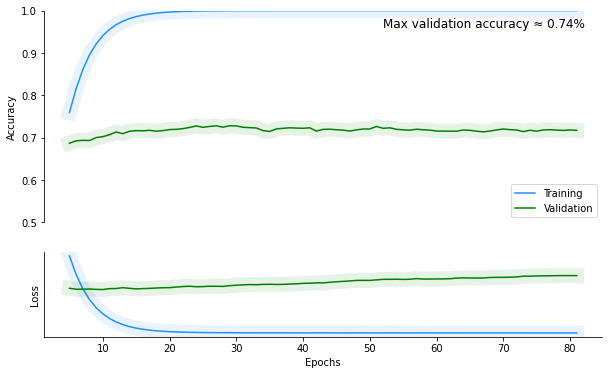

In [ ]:
plot_history(history_aug,xkcd=False)

## Augmented data: Rotation 90 degrees

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20)

Found 553 images belonging to 5 classes.


In [ ]:
model_aug=Sequential()
model_aug.add(conv)
#model_aug.add(InputLayer((7,7,512)))
model_aug.add(Flatten())
model_aug.add(Dense(512, activation='relu',input_shape=(None,25088)))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(5,activation='softmax'))

model_aug.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

history_aug=model_aug.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/rotated_data',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1)
              ]
    )

Epoch 1/1000
28/28 - 10s - loss: 5.7561 - acc: 0.2694 - val_loss: 1.7357 - val_acc: 0.4186

Epoch 00001: val_acc improved from -inf to 0.41860, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/rotated_data
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/rotated_data/assets
Epoch 2/1000
28/28 - 8s - loss: 1.2135 - acc: 0.5190 - val_loss: 1.0996 - val_acc: 0.5814

Epoch 00002: val_acc improved from 0.41860 to 0.58140, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/rotated_data
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/rotated_data/assets
Epoch 3/1000
28/28 - 7s - loss: 1.0145 - acc: 0.6130 - val_loss: 0.8951 - val_acc: 0.6047

Epoch 00003: val_acc improved from 0.58140 to 0.60465, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/V

In [ ]:
model_aug.evaluate(aug_test)

7/7 [==============================] - 1s 190ms/step - loss: 0.7335 - acc: 0.7795


[0.7334578633308411, 0.7795275449752808]

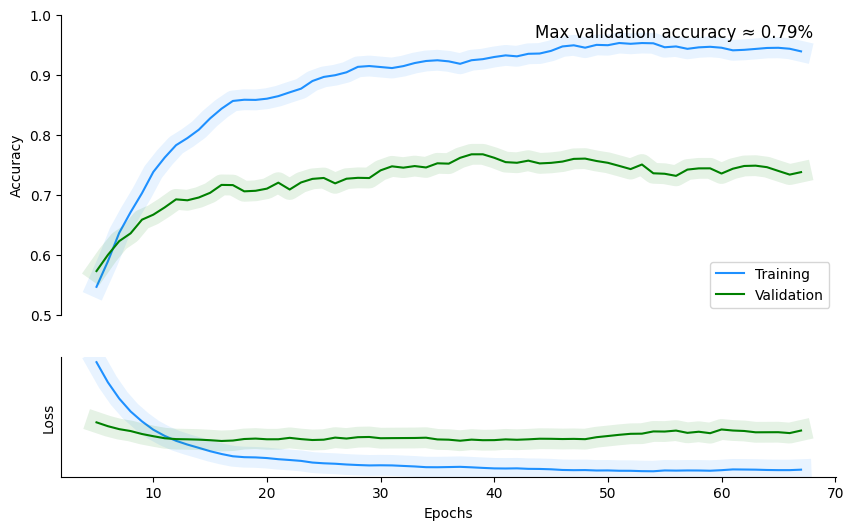

In [ ]:
plot_history(history_aug,xkcd=False)

## **Using Pre-trained Layers for Fine-Tuning**

In [ ]:
breeds=['chow','collie','cairn','dhole','dingo']

In [ ]:
classes=len(breeds)

In [ ]:
def create_model(n_classes,tuning_layers):

  #Import the pre-trained VGG model without the fully connected layers on top
  conv_vgg=VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

  #setting the fine-tuning loop
  if tuning_layers==0:
    conv_vgg.trainable=False
  else:
    for layer in conv_vgg.layers[:-tuning_layers]:
      layer.trainable=False

  #bootstrapping a new top_model into the pre-trained model

  model=Sequential()
  model.add(conv_vgg)
  model.add(Flatten())
  model.add(Dense(512, activation='relu',input_shape=(None,25088)))
  model.add(Dropout(0.3))
  model.add(Dense(n_classes,activation='softmax'))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
  
  return model

### Without using fine-tuning

In [ ]:
vgg_0=create_model(n_classes=classes, tuning_layers=0)

In [ ]:
vgg_0.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 12,848,133
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
plot_tun0=PlotLossesCallback()

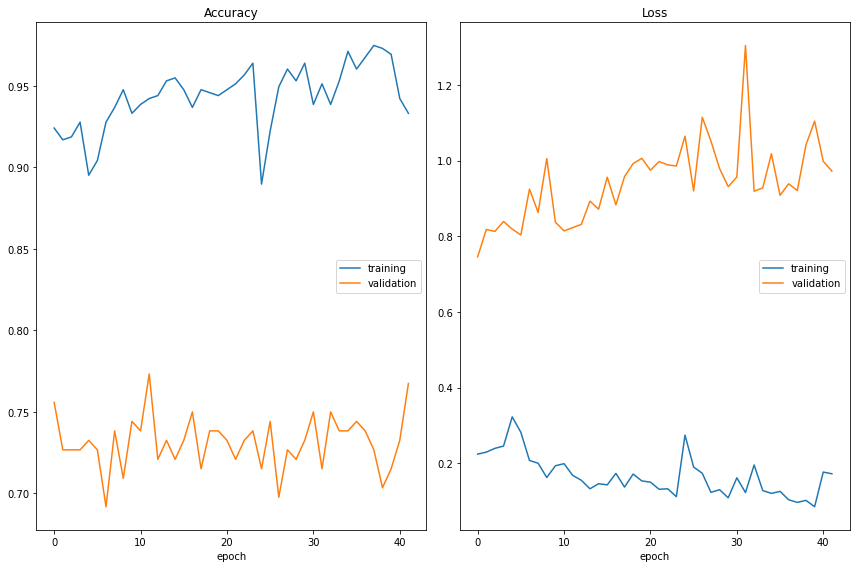

Accuracy
	training         	 (min:    0.890, max:    0.975, cur:    0.933)
	validation       	 (min:    0.692, max:    0.773, cur:    0.767)
Loss
	training         	 (min:    0.085, max:    0.322, cur:    0.172)
	validation       	 (min:    0.746, max:    1.305, cur:    0.972)
Epoch 00042: early stopping


In [ ]:
history_vgg=vgg_0.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0
              ])

In [ ]:
vgg_0.evaluate(aug_test)

7/7 [==============================] - 0s 50ms/step - loss: 0.7337 - acc: 0.7717


[0.7337023019790649, 0.7716535329818726]

### keeping last convolutional layer trainable

In [ ]:
vgg_1=create_model(n_classes=classes, tuning_layers=2)

In [ ]:
vgg_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 15,207,941
Non-trainable params: 12,354,880
_________________________________________________________________


In [ ]:
plot_tun1=PlotLossesCallback()

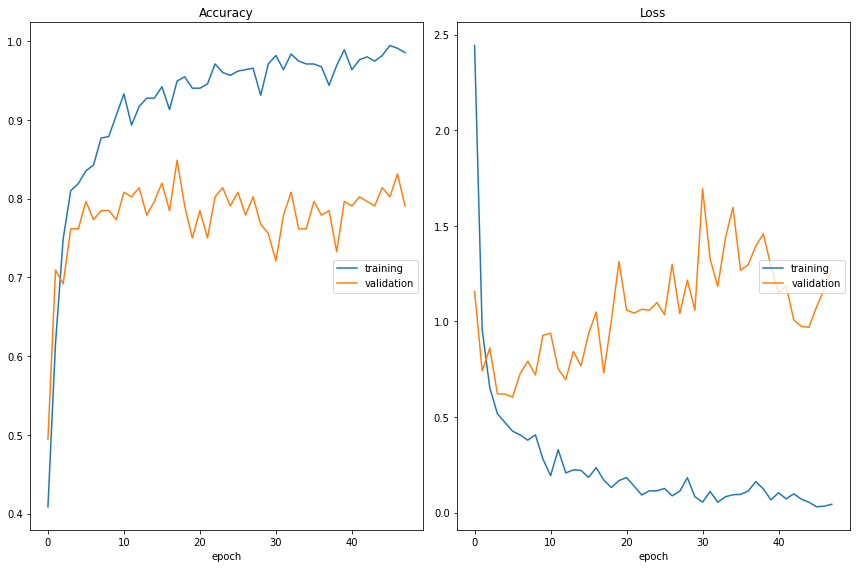

Accuracy
	training         	 (min:    0.409, max:    0.995, cur:    0.986)
	validation       	 (min:    0.494, max:    0.849, cur:    0.791)
Loss
	training         	 (min:    0.031, max:    2.443, cur:    0.043)
	validation       	 (min:    0.605, max:    1.694, cur:    1.273)
Epoch 00048: early stopping


In [ ]:
history_tun1=vgg_1.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1
              ]
    )

In [ ]:
vgg_1.evaluate(aug_test)

7/7 [==============================] - 52s 9s/step - loss: 0.8997 - acc: 0.7559


[0.8996723294258118, 0.7559055089950562]

### keeping two last convolutional layers trainable

In [ ]:
vgg_2=create_model(n_classes=classes, tuning_layers=3)

In [ ]:
vgg_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 17,567,749
Non-trainable params: 9,995,072
_________________________________________________________________


In [ ]:
plot_tun2=PlotLossesCallback()

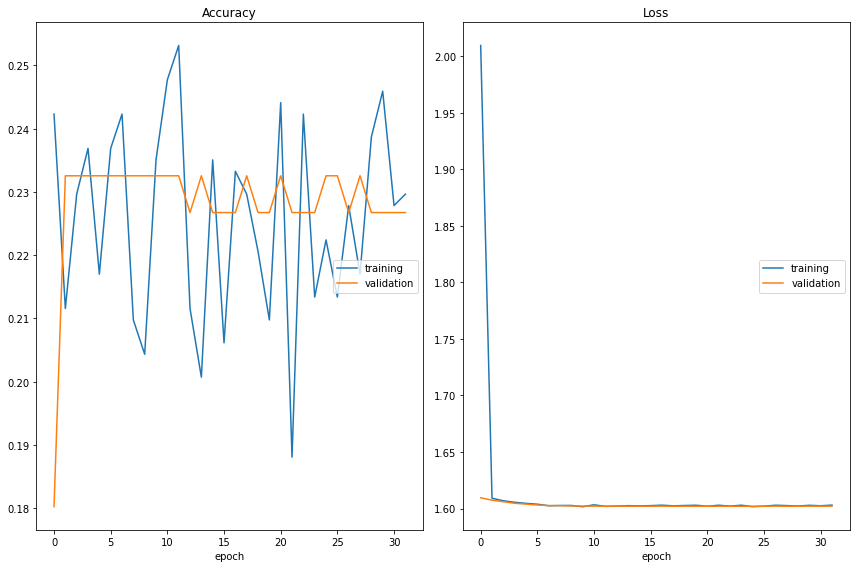

Accuracy
	training         	 (min:    0.188, max:    0.253, cur:    0.230)
	validation       	 (min:    0.180, max:    0.233, cur:    0.227)
Loss
	training         	 (min:    1.602, max:    2.009, cur:    1.603)
	validation       	 (min:    1.602, max:    1.610, cur:    1.602)
Epoch 00032: early stopping


In [ ]:
history_tun2=vgg_2.fit(rotation_train,batch_size=20, epochs=1000, verbose=2,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/fine_tuning_2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2
              ]
    )

In [ ]:
vgg_2.evaluate(aug_test)

7/7 [==============================] - 0s 50ms/step - loss: 1.6074 - acc: 0.2283


[1.6074339151382446, 0.22834645211696625]

# 20 Breeds

In [ ]:
breeds=['basset', 'borzoi', 'Walker_hound', 'bluetick', 'beagle', 'black and tan_coonhound', 'English_foxhound', 'Irish_wolfhound', 'redbone', 'bloodhound', 'Italian_greyhound',
 'whippet', 'Scottish_deerhound', 'Weimaraner', 'Bedlington_terrier', 'American_Staffordshire_terrier', 'Saluki', 'Staffordshire_bullterrier', 'Norwegian_elkhound', 'Ibizan_hound',]

## Setting the data

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20)

Found 2314 images belonging to 20 classes.


In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 712 images belonging to 20 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 534 images belonging to 20 classes.


## No fine tuning

In [ ]:
vgg_0_20breeds=create_model(n_classes=20,tuning_layers=0)

In [ ]:
plot_tun0_20=PlotLossesCallback()

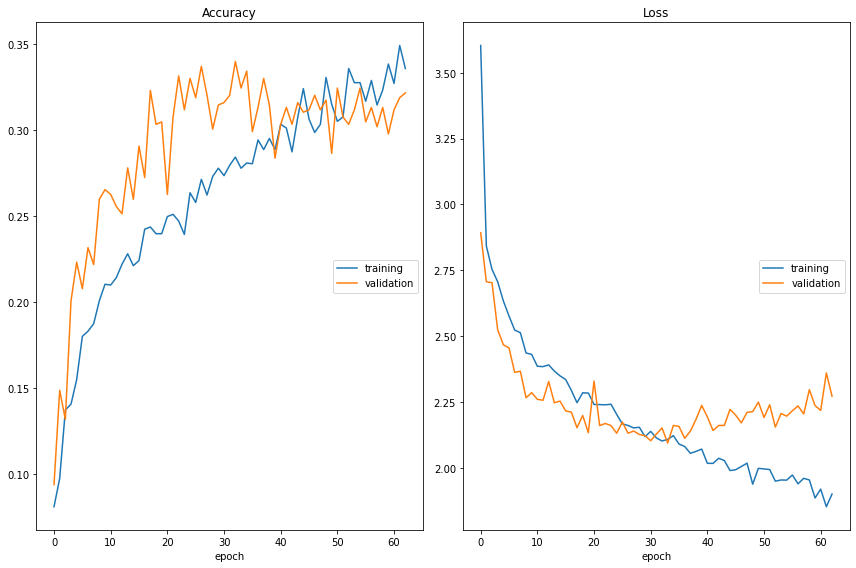

Accuracy
	training         	 (min:    0.081, max:    0.349, cur:    0.336)
	validation       	 (min:    0.094, max:    0.340, cur:    0.322)
Loss
	training         	 (min:    1.852, max:    3.603, cur:    1.900)
	validation       	 (min:    2.094, max:    2.892, cur:    2.272)
Epoch 00063: early stopping


In [ ]:
history_tun0_20breeds=vgg_0_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/20_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_20
              ]
    )

In [ ]:
vgg_0_20breeds.evaluate(aug_test)

27/27 [==============================] - 276s 11s/step - loss: 2.1175 - acc: 0.3071


[2.117544412612915, 0.3071160912513733]

## Fine tuning

In [ ]:
vgg_1_20breeds=create_model(n_classes=20,tuning_layers=2)

In [ ]:
plot_tun1_20=PlotLossesCallback()

In [ ]:
history_tun1_20breeds=vgg_1_20breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/20_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_20
              ]
    )

In [ ]:
vgg_1_20breeds.evaluate(aug_test)

27/27 [==============================] - 2s 57ms/step - loss: 3.5159 - acc: 0.4363


[3.5159153938293457, 0.43632957339286804]

# 120 Breeds

## Setting the data

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20)

Found 13297 images belonging to 119 classes.


In [7]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 4055 images belonging to 119 classes.


In [8]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 3037 images belonging to 119 classes.


## No Fine tuning

In [ ]:
vgg_0_120breeds=create_model(n_classes=119,tuning_layers=2)

In [ ]:
plot_tun1_120=PlotLossesCallback()

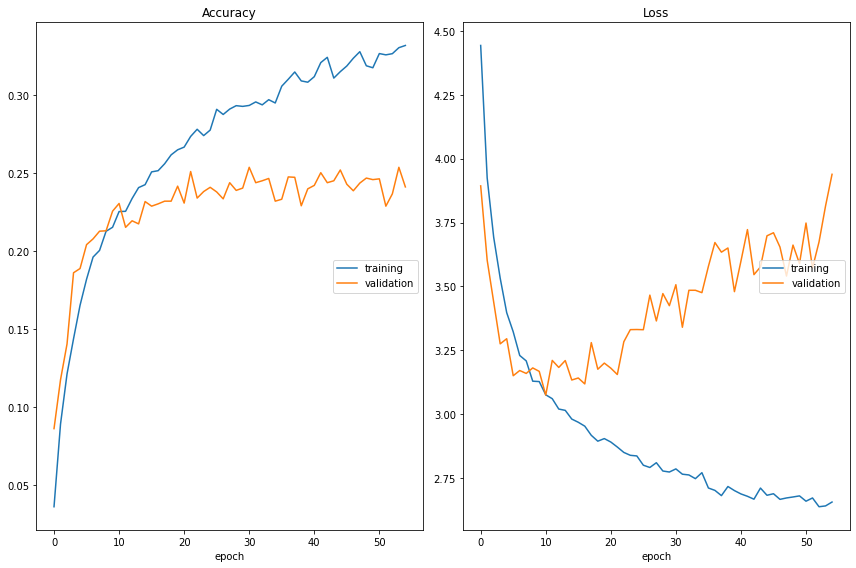

Accuracy
	training         	 (min:    0.036, max:    0.332, cur:    0.332)
	validation       	 (min:    0.086, max:    0.254, cur:    0.241)
Loss
	training         	 (min:    2.637, max:    4.443, cur:    2.656)
	validation       	 (min:    3.074, max:    3.939, cur:    3.939)
Epoch 56/1000
147/665 [=====>........................] - ETA: 2:01 - loss: 2.5552 - acc: 0.3276

In [ ]:
history_tun1_120breeds=vgg_1_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/120_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_20
              ]
    )

In [ ]:
vgg_0_120breeds=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/120_breeds/no_fine_tuning')

In [ ]:
vgg_0_120breeds.evaluate(aug_test)

152/152 [==============================] - 1464s 10s/step - loss: 4.7733 - acc: 0.0076


[4.773256301879883, 0.007573263254016638]

## Fine tuning

In [ ]:
vgg_1_120breeds=create_model(n_classes=119,tuning_layers=2)

In [ ]:
plot_tun1_120=PlotLossesCallback()

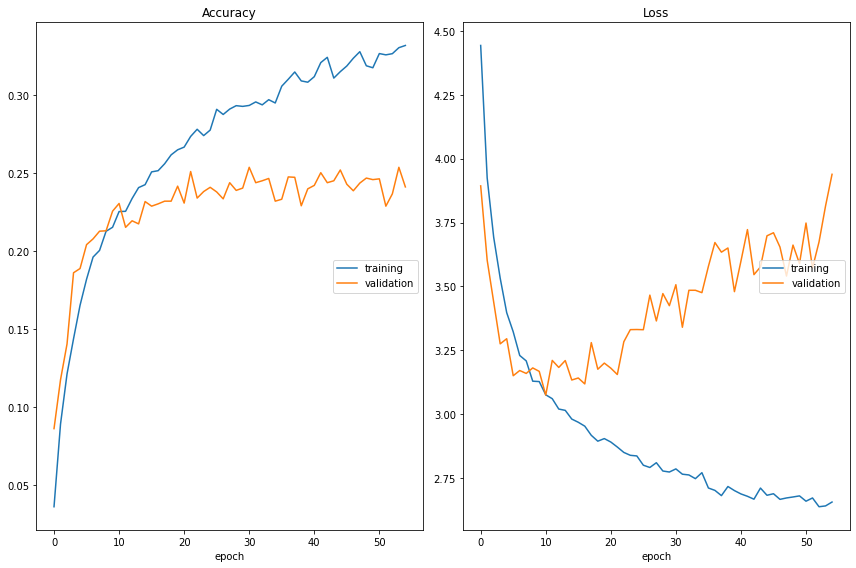

Accuracy
	training         	 (min:    0.036, max:    0.332, cur:    0.332)
	validation       	 (min:    0.086, max:    0.254, cur:    0.241)
Loss
	training         	 (min:    2.637, max:    4.443, cur:    2.656)
	validation       	 (min:    3.074, max:    3.939, cur:    3.939)
Epoch 56/1000
147/665 [=====>........................] - ETA: 2:01 - loss: 2.5552 - acc: 0.3276

In [ ]:
history_tun1_120breeds=vgg_1_120breeds.fit(rotation_train,batch_size=20, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/120_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_20
              ]
    )

In [10]:
vgg_1_120breeds=load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/VGG16/120_breeds/fine_tuning')

In [12]:
vgg_1_120breeds.evaluate(aug_test)

152/152 [==============================] - 1434s 9s/step - loss: 3.5008 - acc: 0.2496


[3.5008058547973633, 0.24958841502666473]